In [63]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import sys
from tqdm import tqdm

import cv2
import numpy as np

from scipy import fft
from scipy.signal import convolve
from scipy.constants import pi

import matplotlib.pyplot as plt

import diffractsim as ds

sys.path.append("E:/Dropbox/py_projects/optics/src")
import fourierhelper as fo

mm_ = 1e-3
um_ = 1e-6
nm_ = 1e-9


from diffractsim import set_backend, MonochromaticField, PolychromaticField, cf, nm, mm, cm, CircularAperture, RectangularSlit, Lens, ApertureFromImage
set_backend("CPU") #Change the string to "CUDA" to use GPU acceleration

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## diffraction grating


1e+34

In [168]:
# Electric field
U_WAVELENGTH = 632 * nm_
U_WAVENUMBER = 2*pi / U_WAVELENGTH
GAUSS_W0 = 2.0 * mm_
GAUSS_DIST_FROM_WAIST = 0.0 * mm_

# propagation
DIST_PROPAGATE = 7.0

# meshing array
U_PIXELPITCH = 25.0 * um_
U_SIZE_N = 1024

rowvec = U_PIXELPITCH * np.linspace( -U_SIZE_N//2, U_SIZE_N//2-1, U_SIZE_N, dtype=np.float64)
xx, yy =  np.meshgrid( rowvec, rowvec )
U_0_XWIDTH = 200 * um_
U_0_YWIDTH = 200 * um_

# gaussian e-field
Egauss = fo.efield_guassian_2d( xx, yy, U_WAVELENGTH, GAUSS_W0, GAUSS_DIST_FROM_WAIST )
# grating
ARRAY_SPACING_X = 600 * um_
ARRAY_SPACING_Y = 600 * um_
ncentersx, ncentersy = 16, 16
ARRAY_SPAN_X = ARRAY_SPACING_X * ncentersx
ARRAY_SPAN_Y = ARRAY_SPACING_Y * ncentersy

x_centers, y_centers = np.meshgrid( np.linspace(-ncentersx//2, ncentersx//2, ncentersx), np.linspace(-ncentersy//2, ncentersy//2, ncentersy) )
x_centers = ARRAY_SPACING_X * x_centers.reshape((-1, ))
y_centers = ARRAY_SPACING_Y * y_centers.reshape((-1, ))

# rng = np.random.default_rng(seed=230123)
# x_centers = ARRAY_SPAN_X*(rng.random(ncentersx*ncentersy) - 0.5)
# y_centers = ARRAY_SPAN_Y*(rng.random(ncentersx*ncentersy) - 0.5)

U_0 = np.zeros_like(xx)
for x0,y0 in tqdm(zip(x_centers, y_centers)):
    U_0 = U_0 + fo.rect2d(xx, yy, x0, y0, U_0_XWIDTH, U_0_YWIDTH)

U_0 = Egauss * U_0
# init monochromatic sim
F = ds.MonochromaticField(U_WAVELENGTH, U_PIXELPITCH*U_SIZE_N, U_PIXELPITCH*U_SIZE_N, U_SIZE_N, U_SIZE_N )
# # make initial field
F.E = U_0.copy()

# # F.propagate(Z)
ccd_size_x, ccd_size_y = 0.2, 0.2
# ccd_size_x, ccd_size_y = U_SIZE_N*U_PIXELPITCH, U_SIZE_N*U_PIXELPITCH
F.zoom_propagate(DIST_PROPAGATE, x_interval=[-ccd_size_x/2, ccd_size_x/2], y_interval=[-ccd_size_y/2, ccd_size_y/2])
U_z = F.E.copy() # diffraction of initial field

# # CCD meshgrid i.e. output screen 
# xvec = np.linspace(-ccd_size_x/2, ccd_size_x/2, U_SIZE_N)
# yvec = np.linspace(-ccd_size_y/2, ccd_size_y/2, U_SIZE_N)
# ccd_xx, ccd_yy = np.meshgrid( xvec, yvec )



256it [00:02, 101.03it/s]


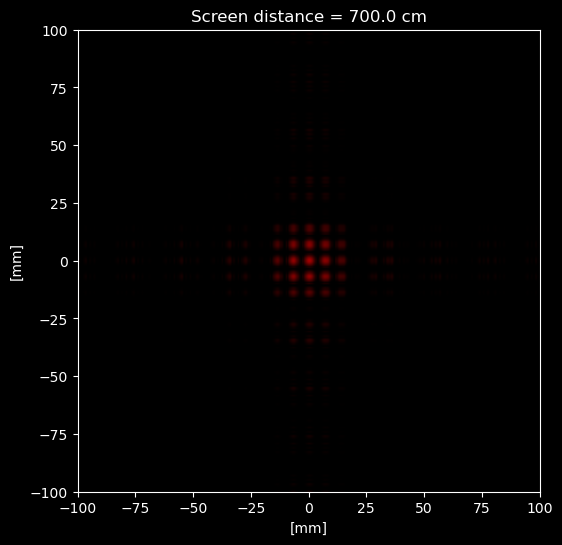

In [169]:

rgb =F.get_colors()
F.plot_colors(rgb, xlim=[-ccd_size_x/2, ccd_size_x/2], ylim=[-ccd_size_y/2, ccd_size_y/2])


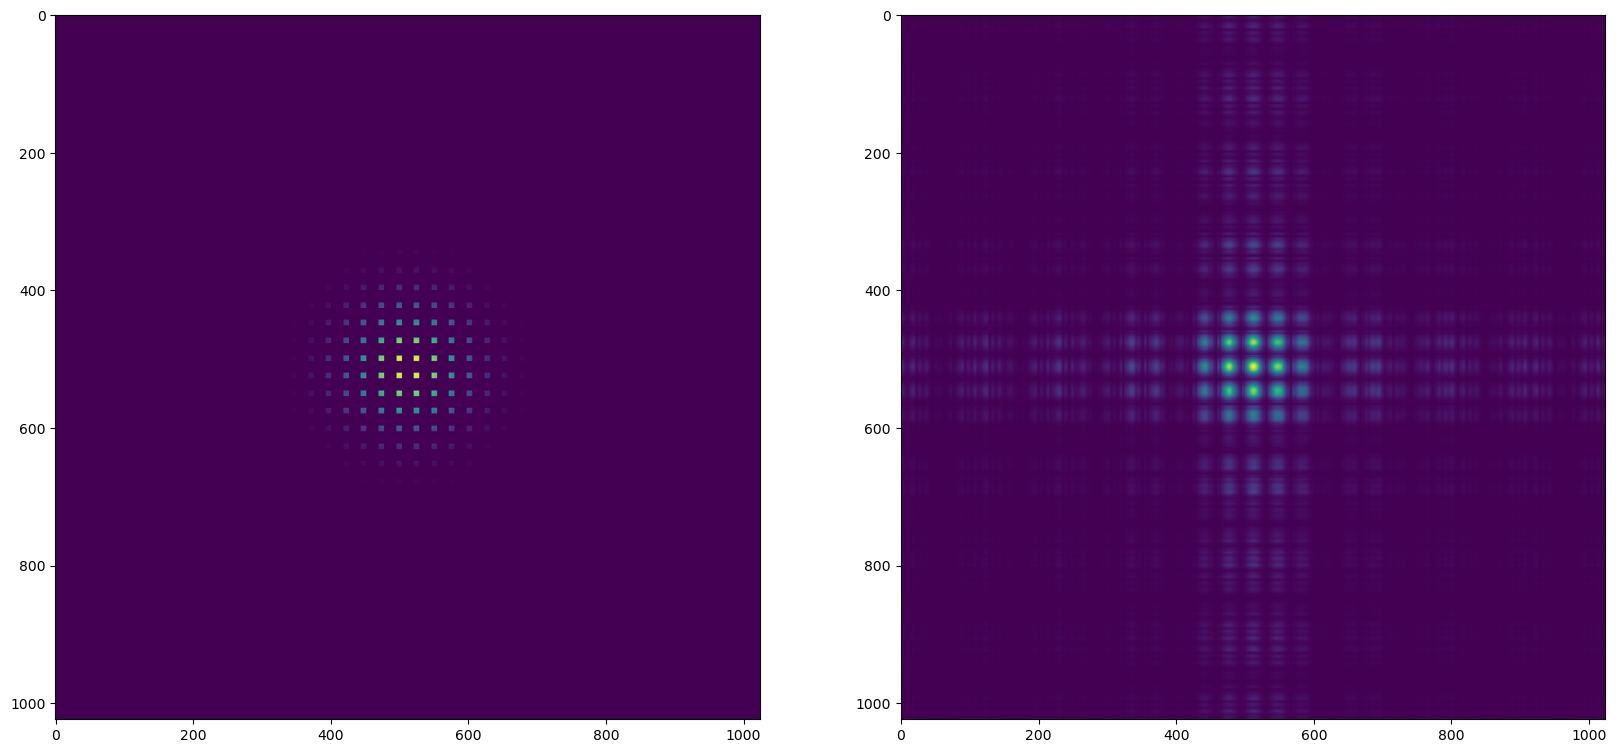

In [170]:
plt.style.use('default')
fig, (ax_u0, ax_uz ) = plt.subplots(1,2, figsize=(20,15))


ax_u0.imshow(np.abs(U_0))
# ax_u0.imshow(np.abs(convolve( U_0, form_array, mode='same', method='auto')))

ax_uz.imshow( np.abs(U_z), cmap='viridis' )

plt.show()

## telescope

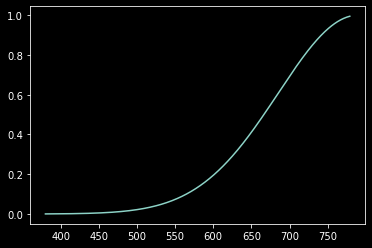

In [91]:
spectfn = "E:/diffractsim/diffractsim/data/illuminant_d65.txt"
# spectfn = "E:/diffractsim/diffractsim/data/compact_fluorescent_lamp.txt"
spect_ = np.loadtxt(spectfn)

wavelen_min, wavelen_max = 380, 779 # nm
wavelen_range = np.linspace(wavelen_min, wavelen_max, 400)

spect_ = (1/(wavelen_max-wavelen_min)) * np.ones_like(wavelen_range)

spect_ = np.exp( -(wavelen_range - 790)**2 / (2 * 105**2))

plt.plot(wavelen_range, spect_)

100% |########################################################################|


Computation Took 58.17607641220093


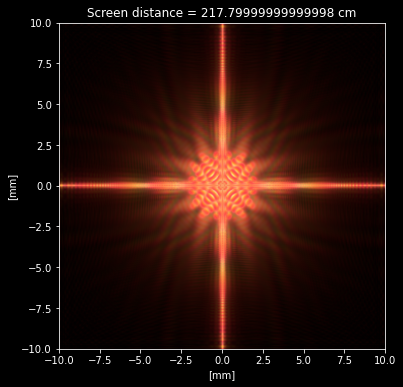

In [96]:
EXTENT_INIT_X = 20.0 * mm
EXTENT_INIT_Y = 20.0 * mm
F = PolychromaticField( spectrum=spect_, extent_x=EXTENT_INIT_X, extent_y=EXTENT_INIT_Y, Nx=1024, Ny=1024)
# F = MonochromaticField( wavelength=632*nm, extent_x=EXTENT_INIT_X, extent_y=EXTENT_INIT_Y, Nx=1024, Ny=1024)

CIRC_RADIUS = 1.0*mm
# F.add(CircularAperture(radius=CIRC_RADIUS, x0=0.0*mm, y0=0.0*mm))

F.add(ApertureFromImage("E:/Dropbox/py_projects/optics/images/orion_mirror_obscure.png", image_size=(EXTENT_INIT_X, EXTENT_INIT_Y), simulation = F))

FOCAL_LEN = 1178*mm
MIRROR_1_DIST = 1.0
F.propagate(MIRROR_1_DIST, spectrum_divisions=10)

MIRROR_1_RADIUS = 8.0*25.4*mm
F.add(CircularAperture(radius=MIRROR_1_RADIUS, x0=0.0*mm, y0=0.0*mm))
F.add(Lens(f = FOCAL_LEN))
# F.add(Lens(f = FOCAL_LEN))

MIRROR_2_DIST = 95*cm
F.propagate(MIRROR_2_DIST, spectrum_divisions=10)
MIRROR_2_RADIUS = 2.0*25.4*mm
F.add(CircularAperture(radius=MIRROR_2_RADIUS, x0=0.0*mm, y0=0.0*mm))

F.propagate(FOCAL_LEN-MIRROR_2_DIST, spectrum_divisions=10)

rgb =F.get_colors()
EXTENT_CCD_X, EXTENT_CCD_Y = 20*mm, 20*mm
F.plot_colors(rgb, xlim=[-EXTENT_CCD_X/2, EXTENT_CCD_X/2], ylim=[-EXTENT_CCD_Y/2, EXTENT_CCD_Y/2])


100% |########################################################################|


Computation Took 2.2093417644500732


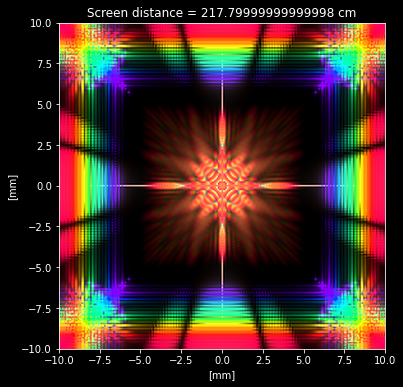

In [97]:
EXTENT_INIT_X = 20.0 * mm
EXTENT_INIT_Y = 20.0 * mm
F = PolychromaticField( spectrum=spect_, extent_x=EXTENT_INIT_X, extent_y=EXTENT_INIT_Y, Nx=256, Ny=256)
# F = MonochromaticField( wavelength=632*nm, extent_x=EXTENT_INIT_X, extent_y=EXTENT_INIT_Y, Nx=256, Ny=256)

CIRC_RADIUS = 1.0*mm
# F.add(CircularAperture(radius=CIRC_RADIUS, x0=0.0*mm, y0=0.0*mm))

F.add(ApertureFromImage("E:/Dropbox/py_projects/optics/images/orion_mirror_obscure.png", image_size=(EXTENT_INIT_X, EXTENT_INIT_Y), simulation = F))

FOCAL_LEN = 1178*mm
MIRROR_1_DIST = 1.0
F.propagate(MIRROR_1_DIST, spectrum_divisions=10)

MIRROR_1_RADIUS = 8.0*25.4*mm
F.add(CircularAperture(radius=MIRROR_1_RADIUS, x0=0.0*mm, y0=0.0*mm))
F.add(Lens(f = FOCAL_LEN))
# F.add(Lens(f = FOCAL_LEN))

MIRROR_2_DIST = 95*cm
F.propagate(MIRROR_2_DIST, spectrum_divisions=10)
MIRROR_2_RADIUS = 2.0*25.4*mm
F.add(CircularAperture(radius=MIRROR_2_RADIUS, x0=0.0*mm, y0=0.0*mm))

F.propagate(FOCAL_LEN-MIRROR_2_DIST, spectrum_divisions=10)

rgb =F.get_colors()
EXTENT_CCD_X, EXTENT_CCD_Y = 20*mm, 20*mm
F.plot_colors(rgb, xlim=[-EXTENT_CCD_X/2, EXTENT_CCD_X/2], ylim=[-EXTENT_CCD_Y/2, EXTENT_CCD_Y/2])
